In [ ]:

import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import re
from sklearn.model_selection import train_test_split
import joblib



In [2]:
ds = load_dataset('7Xan7der7/us_airline_sentiment')
df = ds['train'].to_pandas()
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,None,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,None,2/24/2015 11:35,None,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,None,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,None,2/24/2015 11:15,None,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,None,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,None,2/24/2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,None,2/24/2015 11:15,None,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,None,2/24/2015 11:14,None,Pacific Time (US & Canada)


In [3]:
df['airline_sentiment'].value_counts()


airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [4]:
df = df[['text','airline_sentiment']]
df.describe(include='all')

,text,airline_sentiment
count,14640,14640
unique,14427,3
top,@united thanks,negative
freq,6,9178


In [5]:
df['airline_sentiment'].nunique()

3

In [6]:
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'http+', '', text)
    text = re.sub(r'@+', '', text)
    text = re.sub(r'[^A-Za-z0-9]', ' ', text)
    text = text.lower().strip()
    return text

df['text'] = df['text'].apply(clean_text)
df = df.drop_duplicates(subset=['text'])
df = df.dropna(subset=['text'])
df.to_csv('./data/processed/batch_processed.csv', index=False)

df.describe(include='all')


,text,airline_sentiment
count,14360,14360
unique,14360,3
top,virginamerica what dhepburn said,negative
freq,1,9079


In [7]:
import nlpaug
import nlpaug.augmenter.word as naw

import nltk
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
aug_synonym = naw.SynonymAug(aug_src='wordnet', aug_min=1, aug_max=3)

aug_insert = naw.SynonymAug(aug_src='wordnet', aug_min=1, aug_max=2, aug_p=0.3)


In [ ]:

def augment_text(text, augmenter, num_augmentations=1):
    augmented_texts = []
    for _ in range(num_augmentations):
        try:
            aug_text = augmenter.augment(text)
            if aug_text and aug_text != text:
                augmented_texts.append(aug_text)
        except:
            continue
    return augmented_texts

print("=" * 60)
print("AUGMENTING MINORITY CLASSES")
print("=" * 60)

negative_df = df[df['airline_sentiment'] == 'negative']
neutral_df = df[df['airline_sentiment'] == 'neutral']
positive_df = df[df['airline_sentiment'] == 'positive']

max_count = len(negative_df)

neutral_needed = max_count - len(neutral_df)
positive_needed = max_count - len(positive_df)

print(f"\nAugmentation targets:")
print(f"  • Neutral class:  {len(neutral_df):,} → {max_count:,} (need {neutral_needed:,} more)")
print(f"  • Positive class: {len(positive_df):,} → {max_count:,} (need {positive_needed:,} more)")

augmented_data = []

print(f"\nAugmenting neutral class...")
neutral_samples = neutral_df.sample(n=neutral_needed, replace=True, random_state=42)
for idx, row in enumerate(neutral_samples.itertuples(), 1):
    if idx % 500 == 0:
        print(f"   Processed {idx}/{neutral_needed}...")
    
    augmenter = aug_synonym if idx % 2 == 0 else aug_insert
    aug_texts = augment_text(row.text, augmenter, num_augmentations=1)
    
    if aug_texts:
        augmented_data.append({
            'airline_sentiment': row.airline_sentiment,
            'text': f" {row.text}"
        })

print(f"Neutral class augmented: {len([d for d in augmented_data if d['airline_sentiment'] == 'neutral'])} new samples")

print(f"\nAugmenting positive class...")
positive_samples = positive_df.sample(n=positive_needed, replace=True, random_state=42)
for idx, row in enumerate(positive_samples.itertuples(), 1):
    if idx % 500 == 0:
        print(f"   Processed {idx}/{positive_needed}...")
    
    augmenter = aug_synonym if idx % 2 == 0 else aug_insert
    aug_texts = augment_text(row.text, augmenter, num_augmentations=1)
    
    if aug_texts:
        augmented_data.append({
            'airline_sentiment': row.airline_sentiment,
            'text': f"{row.text}"
        })

print(f"Positive class augmented: {len([d for d in augmented_data if d['airline_sentiment'] == 'positive'])} new samples")

augmented_df = pd.DataFrame(augmented_data)

AUGMENTING MINORITY CLASSES

Augmentation targets:
  • Neutral class:  3,043 → 9,079 (need 6,036 more)
  • Positive class: 2,238 → 9,079 (need 6,841 more)

⏳ Augmenting neutral class...
   Processed 500/6036...
   Processed 1000/6036...
   Processed 1500/6036...
   Processed 2000/6036...
   Processed 2500/6036...
   Processed 3000/6036...
   Processed 3500/6036...
   Processed 4000/6036...
   Processed 4500/6036...
   Processed 5000/6036...
   Processed 5500/6036...
   Processed 6000/6036...
✓ Neutral class augmented: 6036 new samples

⏳ Augmenting positive class...
   Processed 500/6841...
   Processed 1000/6841...
   Processed 1500/6841...
   Processed 2000/6841...
   Processed 2500/6841...
   Processed 3000/6841...
   Processed 3500/6841...
   Processed 4000/6841...
   Processed 4500/6841...
   Processed 5000/6841...
   Processed 5500/6841...
   Processed 6000/6841...
   Processed 6500/6841...
✓ Positive class augmented: 6841 new samples


In [9]:
df_balanced = pd.concat([df, augmented_df], ignore_index=True)

df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
df.describe()


,text,airline_sentiment
count,27237,27237
unique,16958,3
top,virginamerica wow this just blew my mind,negative
freq,12,9079


In [11]:
embed_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

df = df.reset_index(drop=True)
embeddings = embed_model.encode(df['text'], show_progress_bar=True, convert_to_numpy=True)

Batches:   0%|          | 0/852 [00:00<?, ?it/s]

In [12]:
embeddings

array([[ 0.5429377 , -0.25727424, -0.06969853, ..., -0.6575042 ,
        -0.6736789 , -0.08332174],
       [-0.00457585,  0.12380767,  0.3188933 , ..., -0.02518826,
        -0.7078762 ,  0.05382101],
       [ 0.53501433, -0.01915778,  0.1283991 , ...,  0.169671  ,
        -0.57458156,  0.4460113 ],
       ...,
       [ 0.15921551, -0.17342187, -0.09685306, ..., -0.3815624 ,
        -0.3598306 ,  0.11176706],
       [-0.17364743,  0.1154588 ,  0.13479452, ..., -0.25577426,
         0.14693817,  0.11060773],
       [ 0.02555208,  0.0655887 , -0.1987001 , ..., -0.33140555,
         0.56891775, -0.30336943]], shape=(27237, 384), dtype=float32)

In [13]:
import math
import chromadb

chroma_client = chromadb.Client()


collection = chroma_client.create_collection(
    name="aerostream_reviews",
    
)

documents = df["text"].astype(str).tolist()

metadatas = [
    {
        "review_id": int(i),
        "airline_sentiment": row["airline_sentiment"]
    }
    for i, row in df.reset_index().iterrows()
]

ids = [str(i) for i in range(len(documents))]

BATCH_SIZE = 5000
num_batches = math.ceil(len(ids) / BATCH_SIZE)

for batch_idx in range(num_batches):
    start = batch_idx * BATCH_SIZE
    end = start + BATCH_SIZE

    collection.add(
        ids=ids[start:end],
        embeddings=embeddings[start:end].tolist(),
        documents=documents[start:end],
        metadatas=metadatas[start:end],
    )

    print(f"Inserted batch {batch_idx + 1}/{num_batches}")

print(f"\nStored {len(ids)} vectors successfully in ChromaDB")


Inserted batch 1/6
Inserted batch 2/6
Inserted batch 3/6
Inserted batch 4/6
Inserted batch 5/6
Inserted batch 6/6

Stored 27237 vectors successfully in ChromaDB


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report , f1_score
from sklearn.metrics import confusion_matrix 


all_items = collection.get(include=['embeddings','metadatas','documents'])
X = embeddings  
y = df['airline_sentiment'].values
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, df.index, test_size=0.2, random_state=42, stratify=y)


def evaluate_model(name , model):
    print(f"=== {name} ===") 

    train_acc = model.score(X_train, y_train) 
    test_pred = model.predict(X_test) 
    test_acc = accuracy_score(y_test, test_pred) 
    
    f1 = f1_score(y_test, test_pred, average="macro") 

    print("Train accuracy:", train_acc) 
    print("Test accuracy :", test_acc) 
    print("F1-score :", f1) 
    print("Gap:", train_acc - test_acc) 
    print(classification_report(y_test, test_pred)) 

    print(confusion_matrix(y_test, test_pred) )



In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression())
])


logreg_pipeline.fit(X_train, y_train)


evaluate_model("svm", logreg_pipeline)

=== svm ===
Train accuracy: 0.7975584010280417
Test accuracy : 0.7773494860499266
F1-score : 0.7779381677763596
Gap: 0.020208914978115056
              precision    recall  f1-score   support

    negative       0.80      0.80      0.80      1816
     neutral       0.71      0.74      0.73      1816
    positive       0.82      0.79      0.81      1816

    accuracy                           0.78      5448
   macro avg       0.78      0.78      0.78      5448
weighted avg       0.78      0.78      0.78      5448

[[1449  270   97]
 [ 256 1352  208]
 [ 106  276 1434]]


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm" ,LinearSVC())
])

svm_pipeline.fit(X_train, y_train)


evaluate_model("svm", svm_pipeline)

=== svm ===
Train accuracy: 0.7981550323557759
Test accuracy : 0.775330396475771
F1-score : 0.775791755262003
Gap: 0.02282463588000494
              precision    recall  f1-score   support

    negative       0.79      0.80      0.79      1816
     neutral       0.72      0.74      0.73      1816
    positive       0.82      0.79      0.81      1816

    accuracy                           0.78      5448
   macro avg       0.78      0.78      0.78      5448
weighted avg       0.78      0.78      0.78      5448

[[1447  267  102]
 [ 271 1342  203]
 [ 114  267 1435]]


In [20]:
rf = RandomForestClassifier(
    n_jobs=-1,
)

rf.fit(X_train, y_train)

evaluate_model("rf", rf)

=== rf ===
Train accuracy: 0.999816421129928
Test accuracy : 0.952826725403818
F1-score : 0.9527371172924185
Gap: 0.04698969572611
              precision    recall  f1-score   support

    negative       0.94      0.93      0.94      1816
     neutral       0.94      0.95      0.94      1816
    positive       0.97      0.99      0.98      1816

    accuracy                           0.95      5448
   macro avg       0.95      0.95      0.95      5448
weighted avg       0.95      0.95      0.95      5448

[[1684  104   28]
 [  81 1717   18]
 [  19    7 1790]]


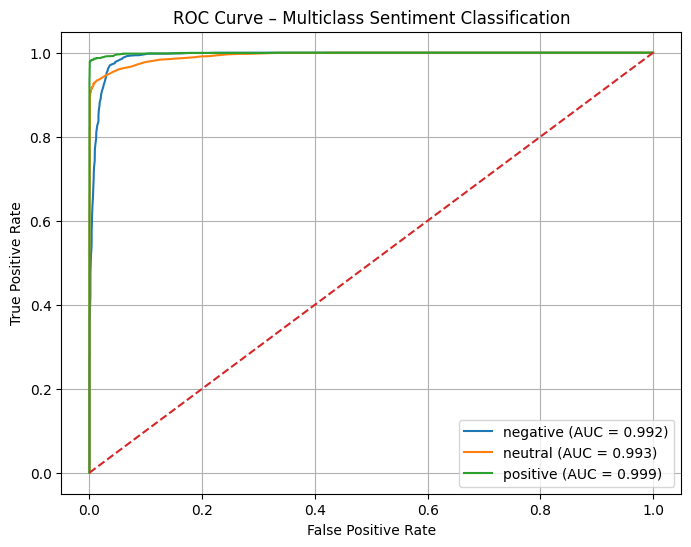

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_score = rf.predict_proba(X_test)
classes = rf.classes_

y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f"{classes[i]} (AUC = {roc_auc[i]:.3f})"
    )

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Multiclass Sentiment Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
joblib.dump(rf, './models/rf_sentiment_model.pkl')
print('Model Saved best')

NameError: name 'joblib' is not defined